<a href="https://colab.research.google.com/github/Nidzoki/2025-sci-prog/blob/main/7/7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


def create_test_image_rgb(size=200):
    """Kreira testnu RGB sliku s jasnim granicama za vizualizaciju rubova."""
    img = Image.new('RGB', (size, size), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)
    # Crveni pravokutnik
    draw.rectangle([50, 50, 150, 100], fill=(255, 0, 0))
    # Zeleni krug
    draw.ellipse([60, 120, 140, 180], fill=(0, 255, 0))
    # Normalizacija na [0, 1]
    img_array = np.array(img, dtype=np.float64) / 255.0
    return img_array

def min_max_normalize(matrix):
    """Normalizira matricu na raspon [0, 1] za ispravan prikaz."""
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    if max_val == min_val:
        return np.zeros_like(matrix)
    return (matrix - min_val) / (max_val - min_val)

def visualize_feature_maps(input_image, feature_maps, title):
    """Prikazuje ulaznu sliku i sve generirane feature mape."""
    num_maps = feature_maps.shape[2]

    cols = min(num_maps, 4)
    rows = (num_maps + cols - 1) // cols

    fig, axes = plt.subplots(rows + 1, cols, figsize=(3 * cols, 3 * (rows + 1)))


    if rows == 0:
        ax = axes if num_maps == 1 else axes[0]
        ax.imshow(input_image)
        ax.set_title("Ulazna Slika (RGB)")
        ax.axis('off')
    else:
        axes[0, 0].imshow(input_image)
        axes[0, 0].set_title("Ulazna Slika (RGB)")
        axes[0, 0].axis('off')

        for i in range(1, cols):
            axes[0, i].axis('off')


        for i in range(num_maps):
            row_idx = (i // cols) + 1
            col_idx = i % cols

            fm = feature_maps[:, :, i]
            axes[row_idx, col_idx].imshow(min_max_normalize(fm), cmap='gray')
            axes[row_idx, col_idx].set_title(f"Mapa {i+1}\nDim: {fm.shape}")
            axes[row_idx, col_idx].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

In [63]:
def pad_image(image, padding):
    """
    Implementirajte simetrično nul-padding (Zero-Padding).
    Ulaz:
        image: 3D NumPy array (H, W, C) ili 2D NumPy array (H, W).
        padding: int - Broj piksela za dodavanje na svaku stranu.
    Izlaz:
        Novi NumPy array s dodanim nulama (H+2P, W+2P, C) ili (H+2P, W+2P).
    """
    if padding == 0:
        return image

    # Determine padding dimensions based on image shape
    if image.ndim == 2:
        # For 2D image (H, W)
        pad_width = ((padding, padding), (padding, padding))
    elif image.ndim == 3:
        # For 3D image (H, W, C)
        # Pad H and W dimensions, leave C dimension as is
        pad_width = ((padding, padding), (padding, padding), (0, 0))
    else:
        raise ValueError("Unsupported image dimensions. Expected 2D or 3D.")

    padded_image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=0)
    return padded_image

In [64]:
def calculate_output_dim(input_dim, filter_dim, stride=1, padding=0):
    """
    Izračunajte izlaznu dimenziju (W' ili H') nakon konvolucije/poolinga.
    Formula: W' = floor((W - F + 2P) / S) + 1
    """
    output_dim = np.floor((input_dim - filter_dim + 2 * padding) / stride) + 1
    return int(output_dim)

In [65]:
# Definicija Filtara za demonstraciju: sada 4D tenzor (Filtara, H, W, Kanala)
# Primjer: 2 filtera, oba 3x3 s 3 kanala (za RGB ulaz)
FILTER_BANK = np.stack([
    # Filter 1: Sobel X (detektira vertikalne rubove)
    np.stack([
        np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 4,
        np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 4,
        np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 4
    ], axis=2),
    # Filter 2: Edge Test Y (detektira horizontalne rubove)
    np.stack([
        np.array([[ 1,  1,  1], [ 0,  0,  0], [-1, -1, -1]]),
        np.array([[ 1,  1,  1], [ 0,  0,  0], [-1, -1, -1]]),
        np.array([[ 1,  1,  1], [ 0,  0,  0], [-1, -1, -1]])
    ], axis=2)
], axis=0) # Ukupna dimenzija: (2, 3, 3, 3)


In [66]:
def apply_convolution_layer(image_3d, filter_bank_4d, stride=1, padding=0):
    """
    Primijenite CIJELU BANKU FILTERA na ulaznu sliku.
    Ulaz:
        image_3d: (H, W, C)
        filter_bank_4d: (Num_Filters, F_H, F_W, C)
    Izlaz:
        Tenzor feature mapa: (Out_H, Out_W, Num_Filters)
    """
    Num_Filters = filter_bank_4d.shape[0]
    F_H = filter_bank_4d.shape[1]
    F_W = filter_bank_4d.shape[2]
    H, W, C_in = image_3d.shape

    # Izračunajte Out_H i Out_W (koristite calculate_output_dim)
    Out_H = calculate_output_dim(H, F_H, stride, padding)
    Out_W = calculate_output_dim(W, F_W, stride, padding)

    # Inicijalizirajte izlazni tenzor (Out_H, Out_W, Num_Filters)
    output_feature_maps = np.zeros((Out_H, Out_W, Num_Filters))

    # Petlja preko SVAKOG FILTRA u filter_bank_4d
    for i in range(Num_Filters):
        current_filter = filter_bank_4d[i]
        # Primijeni apply_convolution_3d_single_filter na tekući filter
        feature_map_2d = apply_convolution_3d_single_filter(image_3d, current_filter, stride, padding)
        output_feature_maps[:, :, i] = feature_map_2d

    return output_feature_maps

In [67]:
def apply_convolution_2d(input_2d, kernel_2d, stride=1, padding=0):
    """
    Implementirajte 2D konvoluciju, uključujući padding i stride.
    Napomena: Koristite pad_image() unutar ove funkcije ako je padding > 0.
    """
    H, W = input_2d.shape
    F = kernel_2d.shape[0]

    # Apply padding if needed
    input_padded = pad_image(input_2d, padding)

    H_p, W_p = input_padded.shape
    out_H = calculate_output_dim(H, F, stride, padding)
    out_W = calculate_output_dim(W, F, stride, padding)

    output = np.zeros((out_H, out_W))

    # Nested loops for sliding window
    for i in range(out_H):
        for j in range(out_W):
            h_start = i * stride
            h_end = h_start + F
            w_start = j * stride
            w_end = w_start + F

            window = input_padded[h_start:h_end, w_start:w_end]
            output[i, j] = np.sum(window * kernel_2d)

    return output

In [68]:
def apply_convolution_3d_single_filter(image_3d, kernel_3d, stride=1, padding=0):
    """
    Primijenite 3D kernel (FxFxC) na 3D sliku (HxWxC) da biste dobili
    JEDAN 2D Feature Map.
    Logika: Konvolucija 2D dijelova po kanalu, zatim ZBRAJANJE rezultata.
    """
    H, W, C_image = image_3d.shape
    F_H, F_W, C_kernel = kernel_3d.shape

    # Ensure kernel and image have the same number of channels
    if C_image != C_kernel:
        raise ValueError("Number of channels in image and kernel must match for 3D convolution.")

    # Calculate output dimensions (assuming square filter F_H == F_W)
    out_H = calculate_output_dim(H, F_H, stride, padding)
    out_W = calculate_output_dim(W, F_W, stride, padding)

    # Inicijalizirajte Feature Map
    feature_map = np.zeros((out_H, out_W), dtype=image_3d.dtype)

    # Petlja preko KANALA (c)
    for c in range(C_image):
        # Izdvoji 2D sliku i 2D kernel za tekući kanal
        image_2d_channel = image_3d[:, :, c]
        kernel_2d_channel = kernel_3d[:, :, c]

        # Primijeni apply_convolution_2d na te kanale
        convolved_channel = apply_convolution_2d(image_2d_channel, kernel_2d_channel, stride, padding)

        # Zbroji izlaz konvolucije s feature_map
        feature_map += convolved_channel

    return feature_map

In [69]:
def relu(matrix):
    """
    Implementirajte Rectified Linear Unit (ReLU).
    """
    return np.maximum(0, matrix)

In [70]:
def max_pooling_3d(feature_maps_3d, pool_size=2, stride=2):
    """
    Implementirajte Max Pooling na 3D tenzoru.
    Pooling se primjenjuje INDIVIDUALNO na svaki 2D kanal Feature Mapa.
    Ulaz:
        feature_maps_3d: (H, W, Num_Channels)
    Izlaz:
        Poolirani tenzor: (Out_H, Out_W, Num_Channels)
    """
    H, W, C = feature_maps_3d.shape

    # Izračunajte Out_H i Out_W
    # Using calculate_output_dim from Zc6tmRpTbpaC
    out_H = calculate_output_dim(H, pool_size, stride, padding=0)
    out_W = calculate_output_dim(W, pool_size, stride, padding=0)

    # Inicijalizirajte izlazni poolirani tenzor
    output = np.zeros((out_H, out_W, C), dtype=feature_maps_3d.dtype)

    # Petlja preko SVAKOG KANALA (c)
    for c in range(C):
        fm_2d = feature_maps_3d[:, :, c]
        # Ugniježđene petlje za klizanje prozora (i i j)
        for i in range(out_H):
            for j in range(out_W):
                # Calculate the start and end indices for the pooling window
                h_start = i * stride
                h_end = h_start + pool_size
                w_start = j * stride
                w_end = w_start + pool_size

                # Extract the window
                window = fm_2d[h_start:h_end, w_start:w_end]

                # Primjena Max Pooling operacije (np.max(window))
                output[i, j, c] = np.max(window)
                # Smještanje rezultata u odgovarajući kanal izlaza

    return output

In [71]:
class ConvBlock:
    """
    Klasa koja simulira jedan sloj u CNN arhitekturi: CONV -> ReLU -> POOL.
    """
    def __init__(self, filter_bank, pool_size=2, stride=1, pool_stride=2, padding=0):
        """Inicijalizacija hiperparametara i banke filtara."""
        self.filter_bank = filter_bank
        self.pool_size = pool_size
        self.stride = stride
        self.pool_stride = pool_stride
        self.padding = padding

        Num_Filters = self.filter_bank.shape[0]
        print(f"Kreiran ConvBlock s {Num_Filters} filtara.")

    def forward(self, input_data):
        """
        Sekvenca: CONV -> ReLU -> POOL
        """
        print(f"\n[Fwd] Ulazne dimenzije: {input_data.shape}")

        # 1. Konvolucija
        output_conv = apply_convolution_layer(input_data, self.filter_bank, self.stride, self.padding)
        print(f"      CONV izlaz: {output_conv.shape}")

        # 2. ReLU
        output_relu = relu(output_conv)

        # 3. Max Pooling
        output_pool = max_pooling_3d(output_relu, self.pool_size, self.pool_stride)
        print(f"      POOL izlaz: {output_pool.shape}")

        return output_pool

Kreiran ConvBlock s 2 filtara.

[Fwd] Ulazne dimenzije: (256, 256, 3)
      CONV izlaz: (256, 256, 2)
      POOL izlaz: (128, 128, 2)
Kreiran ConvBlock s 2 filtara.

[Fwd] Ulazne dimenzije: (128, 128, 2)
      CONV izlaz: (126, 126, 2)
      POOL izlaz: (62, 62, 2)


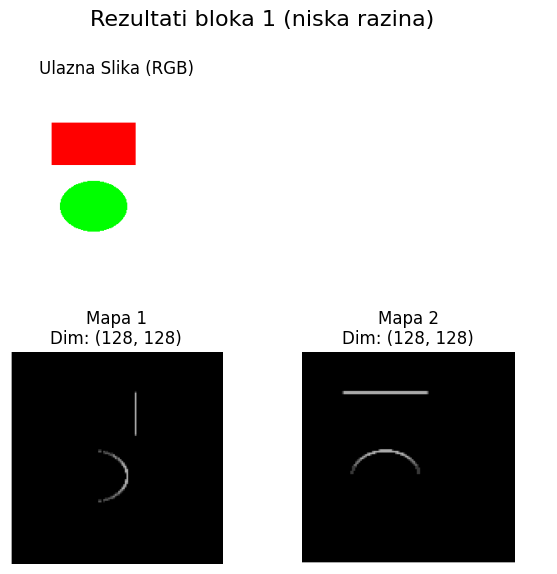

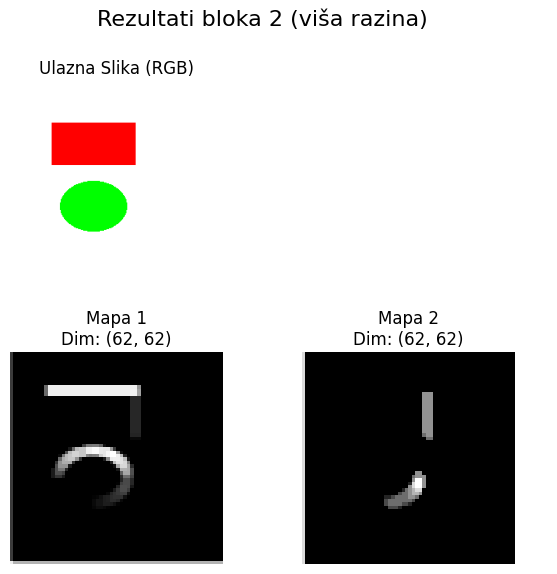

In [72]:
if __name__ == "__main__":

    # Učitavanje/kreiranje ulazne RGB slike
    input_image = create_test_image_rgb(size=256)


    # Stvorite BLOK 1 s bankom filtera definiranom gore (2 filtera)
    block_1 = ConvBlock(
        filter_bank=FILTER_BANK,
        pool_size=2,
        stride=1,
        pool_stride=2, # Pooling će smanjiti dimenzije za 50%
        padding=1      # Dodajte padding da zadržite dimenzije (256x256 -> 256x256 nakon CONV)
    )

    # Izvršavanje prvog bloka
    # Očekivani izlaz: (128, 128, 2)
    feature_maps_1 = block_1.forward(input_image)

    # Kreiranje banke filtera za Blok 2: Ovi filteri sada moraju imati 2 ulazna kanala!
    # Izlaz Bloka 1 ima 2 kanala (Feature Map 1 i Feature Map 2)

    # 2 nova filtera, svaki s dimenzijama 3x3x2
    filter_bank_2 = np.stack([
        np.ones((3, 3, 2)) / 18, # Filter 3: Prosječna boja (blur/smoothing)
        np.array([
            [[ 1,  0,  0], [ 0,  1,  0], [ 0,  0,  1]],
            [[-1,  0,  0], [ 0, -1,  0], [ 0,  0, -1]]
        ]).reshape(2, 3, 3).transpose(1, 2, 0) # Filter 4: Kompliciraniji uzorak
    ], axis=0) # Ukupna dimenzija: (2, 3, 3, 2)


    block_2 = ConvBlock(
        filter_bank=filter_bank_2,
        pool_size=4,
        stride=1,
        pool_stride=2,
        padding=0
    )

    # Izvršavanje drugog bloka na izlazu prvog bloka
    # Očekivani izlaz iz CONV: (126, 126, 2) (padding=0, stride=1)
    # Očekivani izlaz iz POOL (stride=2): (63, 63, 2)
    feature_maps_2 = block_2.forward(feature_maps_1)

    # Vizualizacija (Pozovite tek kada su sve funkcije implementirane)

    visualize_feature_maps(input_image, feature_maps_1, "Rezultati bloka 1 (niska razina)")
    visualize_feature_maps(input_image, feature_maps_2, "Rezultati bloka 2 (viša razina)")